# Problem Set 3

### Before You Start

This problem set is fun but challenging. It's going to involve a good amount of debugging and head-scratching, so try to start sooner rather than later!

This problem set has three parts:

- **Part I**: Experimental Setup
- **Part II**: Nearest Neighbor and Cross-Validation
- **Part III**: Overfitting in Model Selection and Nested Cross Validation

For part I and II we'll consider a regression problem. You should *not* be using any built-in ML libraries for nearest neighbors, distance metrics, or cross-validation -- your mission is to write those algorithms in Python! For these two first parts we will be working with a modified version of the California Housing Dataset that you can download from bcourses (`cal_housing_data_clean.csv`). Part I will be relatively easy; Part II will take more time.

For part III we'll consider a classification problem. You'll be able to use Python ML built-in libraries (in particular scikit-learn). We'll not be using the California Housing Dataset but rather synthetic data that you'll generate yourself. 

Make sure the following libraries load correctly before starting (hit Ctrl-Enter).

In [1]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn
import time

In [2]:
%matplotlib inline  
import matplotlib.pyplot as plt  

---

## Introduction to the assignment

For this assignment, you will be using a version of the [California Housing Prices Dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) with additional information. Use the following commands to load the information in the csv file provided with the assignment in bcourses (`cal_housing_data_clean.csv`). Take some time to explore the data. 

In [3]:
# load Cal data set
cal_df = pd.read_csv('cal_housing_data_clean.csv')
features = ['MedInc','HouseAge','AveRooms','AveBedrms','Population','DistCoast','Inland']
target = 'MedHouseVal'

In [4]:
print(cal_df.head(5))

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup      DistCoast  \
0  3.6885        49  5.184569   1.052950        2363  3.574887    4205.460788   
1  3.5444        12  4.786854   1.027230        2029  1.905164   72365.363970   
2  4.2011         9  6.045161   1.038710        1955  3.153226  166848.071800   
3  3.1630        26  4.267241   0.961207         719  3.099138   28060.624020   
4  4.6197        21  3.701933   1.019329        1489  1.514751    5593.110112   

   Inland  MedHouseVal  
0       0        2.540  
1       1        1.325  
2       1        1.081  
3       0        1.794  
4       0        3.875  


---

# Part I: Experimental Setup

The goal of the next few sections is to design an experiment to predict the median home value for census block groups.
Before beginning the "real" work, refamiliarize yourself with the dataset.

### 1.1 Begin by writing a function to compute the Root Mean Squared Error for a list of numbers

You can find the sqrt function in the Numpy package. Furthermore the details of RMSE can be found on [Wikipedia](http://en.wikipedia.org/wiki/Root-mean-square_deviation). Do not use a built-in function  to compute RMSE, other than numpy functions like `sqrt` and if needed, `sum` or other relevant ones.

In [5]:
"""
Function
--------
compute_rmse

Given two arrays, one of actual values and one of predicted values,
compute the Root Mean Squared Error

Parameters
----------
y_hat : array
    numpy array of numerical values corresponding to predictions for each of the N observations

y : array
    numpy array of numerical values corresponding to the actual values for each of the N observations

Returns
-------
rmse : int
    Root Mean Squared Error of the prediction

Example
-------
>>> print(compute_rmse((4,6,3),(2,1,4)))
3.16
"""
def compute_rmse(y_hat, y):
    # your code here
    mse = np.sum(pow(np.array(y_hat)-np.array(y),2))
    rmse = np.sqrt(mse/len(np.array(y_hat)))
    return rmse

print(compute_rmse((4,6,3),(2,1,4)))

3.1622776601683795


### 1.2 Divide your data into training and testing datasets

Randomly select 75% of the data and put this in a training dataset (call this "cal_df_train"), and place the remaining 25% in a testing dataset (call this "cal_df_test"). Do not use built-in functions.

To perform any randomized operation, only use functions in the *numpy library (np.random)*. Do not use other packages for random functions.

In [26]:
# leave the following line untouched, it will help ensure that your "random" split is the same "random" split used by the rest of the class
np.random.seed(seed=1948)

# your code here
total_samples = len(cal_df)
print('total size:', total_samples)
train_size = int(total_samples * 0.75)
random_indices = np.random.permutation(total_samples)
train_indices = random_indices[:train_size]
test_indices = random_indices[train_size:]

cal_df_train = cal_df.iloc[train_indices]
cal_df_test = cal_df.iloc[test_indices]

print('train size:', len(cal_df_train))
print('test size:', len(cal_df_test))

print(cal_df_train.head(3))
print(cal_df_test.head(3))

total size: 20640
train size: 15480
test size: 5160
      MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
1425  6.6772        13  7.377072   1.067680        2288  3.160221   
639   8.4960        34  7.825971   1.050870        1817  2.432396   
3050  1.6505        50  3.838765   1.154374        2247  3.854202   

         DistCoast  Inland  MedHouseVal  
1425  79883.439580       1      1.85600  
639    1827.026948       0      5.00001  
3050  19359.211980       0      1.25000  
       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
8154   2.1250        45  6.213235   1.139706         343  2.522059   
18791  3.5506        18  4.944334   1.025845         980  1.948310   
7157   3.8000        26  6.876494   1.151394         672  2.677291   

          DistCoast  Inland  MedHouseVal  
8154   113517.31200       1        0.620  
18791   41152.31304       1        1.875  
7157    18217.35751       0        2.421  


### 1.3 Use a baseline for prediction, and compute RMSE 

Let's start by creating a very bad baseline model that predicts median house values as the average of `MedHouseVal`.

Specifically, create a model that predicts, for every observation X_i, the median home value as the average of the median home values of block groups in the **training set**.

Once the model is built, do the following:

1. Report the RMSE of the training set and report it.
2. Report the RMSE of the test data set (but use the model you trained on the training set!).
3. How does RMSE compare for training vs. testing datasets? Is this what you expected, and why?
4. Add code to your function to measure the running time of your algorithm. How long does it take to compute the predicted values for the test data?
5. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis. Color the training instances in blue and the test instances in gold. Make sure to label your axes appropriately, and add a legend to your figure.

2.067938529715762
train rmse:1.1560706527361215
test rmse:1.1474775264840165
Time to compute test predictions: 0.0003792999923462048 seconds


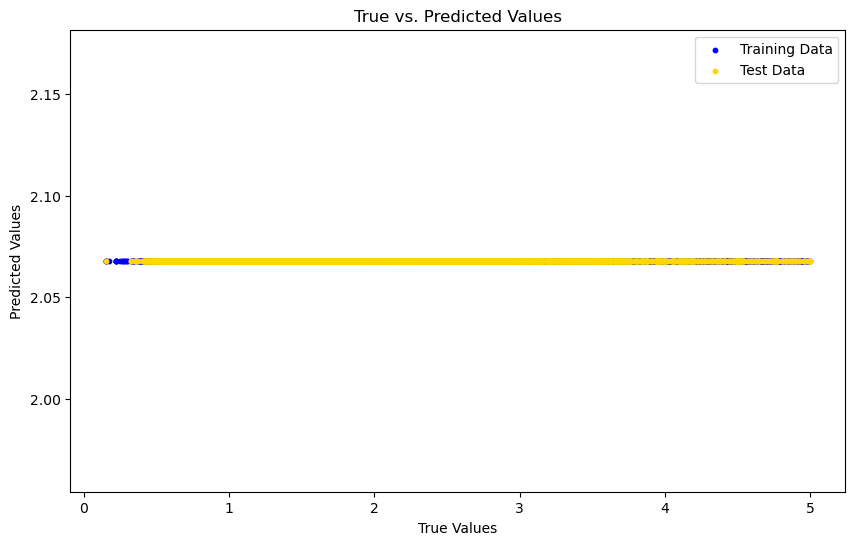

In [28]:
# your code here
trainset = cal_df_train['MedHouseVal']
# average_medval_0 = sum(trainset)/len(trainset)
average_medval_0 = trainset.mean()
print(average_medval_0)
testset = cal_df_test['MedHouseVal']

#rmse
train_pred= [average_medval_0]*len(trainset)  #(average_medval_0,)*len
test_pred = [average_medval_0]*len(testset)
print(f"train rmse:{compute_rmse(train_pred,trainset)}")
print(f"test rmse:{compute_rmse(test_pred,testset)}")

#running time
start_time = time.perf_counter()
_ = [average_medval_0]*len(testset)
end_time = time.perf_counter()
print(f"Time to compute test predictions: {end_time - start_time} seconds")

#scatter plot - show the true value(x) and predicted value(y)
plt.figure(figsize=(10, 6))
plt.scatter(trainset, train_pred, color='blue',s=10, label='Training Data')
plt.scatter(testset, test_pred, color='gold',s=10, label='Test Data')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
plt.legend()
plt.show()

*your answer here*  
* The RMSE in training set is:$1.156$ while the RMSE in test set is:$1.147$. This is not what I expected. But, I think it's reasonable since the baseline model is very bad, which causes the unstability and unaccuracy in the results and prediction.
* It took 0.0003792999923462048 seconds to get the test predictions.

### 1.4 Use another baseline for prediction, and compute RMSE [extra-credit]

Now consider a baseline model that predicts median house values as the averages of `MedHouseVal` based on whether the census block is adjacent to the coast or inland (note that the `Inland` feature is already computed and ready for you).

Specifically, create a model that predicts, for every observation X_i, the median home value as the average of the median home values of block groups in the **training set** that have the same adjacency value.

For example, for an input observation where `Inland==1`, the model should predict the `MedHouseVal` as the average of all `MedHouseVal` values in the training set that also have `Inland==1`.

Once the model is built, do the following:

1. Compute the RMSE of the training set.
2. Now compute the RMSE of the test data set (but use the model you trained on the training set!).
3. How does RMSE compare for training vs. testing datasets? Is this what you expected, and why?
4. Add code to your function to measure the running time of your algorithm. How long does it take to compute the predicted values for the test data?
5. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis. Color the training instances in blue and the test instances in gold. Make sure to label your axes appropriately, and add a legend to your figure to make clear which dots are which.
6. Compare this results to those obtained in 1.3. Is coast adjacency improving the predictions? 

*Note:* The `groupby` operation might come handy here.

Training RMSE (groupby): 1.0119036022521926
Testing RMSE (groupby): 1.0011137151179164
Time to predict test data with groupby: 0.05807232856750488 seconds


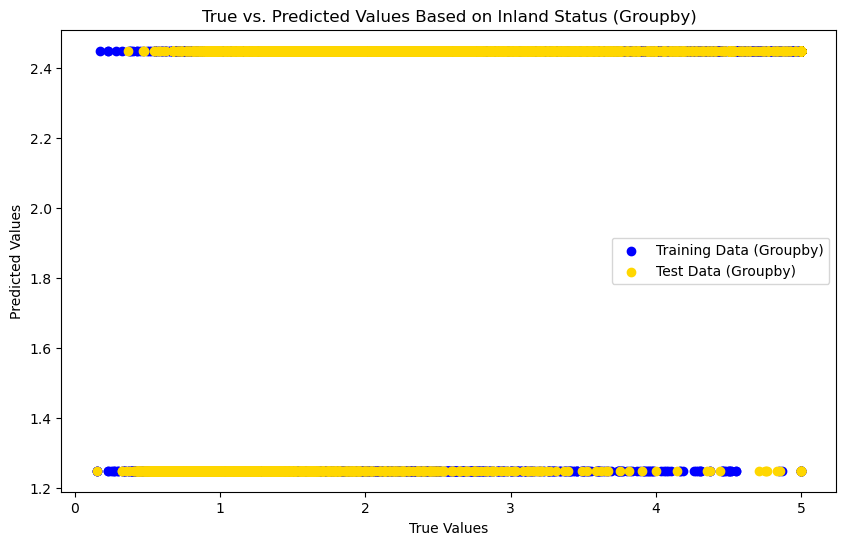

In [29]:
# your code here
# average_medval_inland = cal_df_train[cal_df_train['Inland'] == 1]['MedHouseVal'].mean()
# average_medval_notinland = cal_df_train[cal_df_train['Inland'] == 0]['MedHouseVal'].mean()

# # Prediction function based on Inland status
# def predict(values, avg_inland, avg_notinland):
#     return [avg_inland if x == 1 else avg_notinland for x in values]

avg_medval_by_inland = cal_df_train.groupby('Inland')['MedHouseVal'].mean()

def predict_with_groupby(inland_status, avg_values):
    return avg_values.loc[inland_status]

y_train_pred_groupby = cal_df_train['Inland'].apply(lambda x: predict_with_groupby(x, avg_medval_by_inland))
y_test_pred_groupby = cal_df_test['Inland'].apply(lambda x: predict_with_groupby(x, avg_medval_by_inland))
# print(y_train_pred_groupby)
# print(y_test_pred_groupby)

rmse_train_groupby = compute_rmse(y_train_pred_groupby, cal_df_train['MedHouseVal'])
rmse_test_groupby = compute_rmse(y_test_pred_groupby, cal_df_test['MedHouseVal'])

print(f"Training RMSE (groupby): {rmse_train_groupby}")
print(f"Testing RMSE (groupby): {rmse_test_groupby}")

# running time
start_time = time.time()
_ = cal_df_test['Inland'].apply(lambda x: predict_with_groupby(x, avg_medval_by_inland)) # 用于测量时间的虚拟操作
end_time = time.time()

print(f"Time to predict test data with groupby: {end_time - start_time} seconds")

plt.figure(figsize=(10, 6))
plt.scatter(cal_df_train['MedHouseVal'], y_train_pred_groupby, color='blue', label='Training Data (Groupby)')
plt.scatter(cal_df_test['MedHouseVal'], y_test_pred_groupby, color='gold', label='Test Data (Groupby)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values Based on Inland Status (Groupby)')
plt.legend()
plt.show()



*your answer here*  
* The RMSE in training datasets is $1.0119$, while in test datasets is $1.00111$. It's not what I expected. But it seems that the irrationality decreases because we improved the base model a little bit by considering the binary value of 'Inland'.
* It took 0.05807232856750488 seconds to predict test data with groupby.
* Yes. Considering the coast adjacency improves the predictions. It seems that this factor really affects the MedHouseValue.?
* s

---

# Part II: Nearest Neighbors and Cross-Validation
Let's try and build a machine learning algorithm to beat the "Average Values" baselines that you computed above. Your next task is to implement a basic nearest neighbor algorithm from scratch. 

### 2.1 Nearest Neighbors: Normalization

Create normalized analogues of all the features in both the training and test datasets. Recall that this involves substracting the **training** mean and dividing by the **training** standard deviation. 

Include the normalized features as additional columns in the train an test dataframes and call them 
`MedIncNorm, HouseAgeNorm, AveRoomsNorm, AveBedrmsNorm, PopulationNorm, AveOccupNorm, DistCoastNorm and InlandNorm` respectively.

In [31]:
# your code here

#calculate mean and standard deviation of all features
features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'DistCoast', 'Inland']
means = cal_df_train.loc[:,features].mean()
stds = cal_df_train.loc[:,features].std()

#add normalized features as additional columns in the train and test dfs
for feature in features:
    cal_df_train.loc[:,f'{feature}Norm'] = (cal_df_train.loc[:,feature] - means[feature]) / stds[feature]

for feature in features:
    cal_df_test.loc[:,f'{feature}Norm'] = (cal_df_test.loc[:,feature] - means[feature]) / stds[feature]

print(cal_df_train.head(3))
print(cal_df_test.head(3))

      MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
1425  6.6772        13  7.377072   1.067680        2288  3.160221   
639   8.4960        34  7.825971   1.050870        1817  2.432396   
3050  1.6505        50  3.838765   1.154374        2247  3.854202   

         DistCoast  Inland  MedHouseVal  MedIncNorm  HouseAgeNorm  \
1425  79883.439580       1      1.85600    1.462368     -1.239379   
639    1827.026948       0      5.00001    2.411649      0.432179   
3050  19359.211980       0      1.25000   -1.161205      1.705748   

      AveRoomsNorm  AveBedrmsNorm  PopulationNorm  AveOccupNorm  \
1425      0.746026      -0.060975        0.754832      0.003302   
639       0.918514      -0.094041        0.340271     -0.057439   
3050     -0.613557       0.109565        0.718745      0.061219   

      DistCoastNorm  InlandNorm  
1425       0.797756    1.463684  
639       -0.787884   -0.683163  
3050      -0.431735   -0.683163  
       MedInc  HouseAge  AveRooms  AveBed

### 2.2 Basic Nearest Neighbor algorithm

Use your training data to "fit" your model that predicts `MedHouseVal` from `MedIncNorm`, `HouseAgeNorm` and `AveRoomsNorm`, although as you know, with Nearest Neighbors there is no real training, you just need to keep your training data in memory.  Write a function that predicts the median home value using the nearest neighbor algorithm we discussed in class.  Since this is a small dataset, you can simply compare your test instance to every instance in the training set, and return the `MedHouseVal` value of the closest training instance. Have your function take L as an input, where L is an integer >= 1 representing the norm choice. Use the Euclidean distance (L=2) for all questions henceforth unless explicitly stated otherwise.

Make sure to do the following - 
1. Use your algorithm to predict the median home value of every instance in the test set. Report the RMSE ("test RMSE")
2. Use your algorithm to predict the median home value of every instance in the training set and report the training RMSE.
3. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis.
4. Report an estimate of the total time taken by your code to predict the nearest neighbors for all the values in the test data set.
5. How does the performance (test RMSE and total runtime) of your nearest neighbors algorithm compare to the baseline in part 1.4? Explain the

**Note:** Runtime should not exceed a couple of minutes. If its taking longer then we strongly suggest you go back to your code and make it more efficient. 

Test RMSE: 1.0350385789713217
Training RMSE: 0.002732709325632336
Total prediction time for test set: 0.9284324645996094 seconds


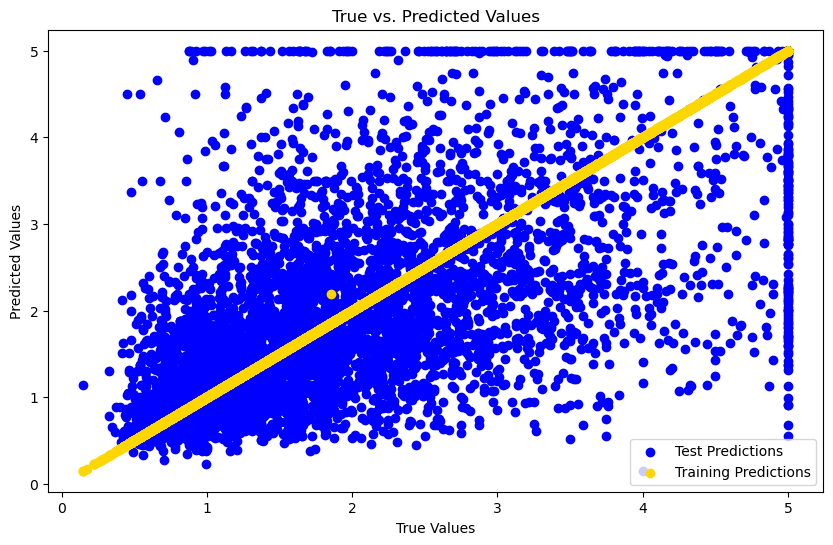

In [35]:
# your code here
def nearest_neighbor_algorithm(X_train,y_train,X_test,L=2):
    preds = []
    cnt = 1
    # print(X_test.head(3))
    for x in X_test.values:
        # distance calculation
        distances = np.linalg.norm(X_train.values-x,axis=1,ord=L)
        # put the first zero value to inf value
        if cnt:
            distances[distances == 0] = np.inf
            cnt-=1
        # get the nearest index
        index_of_nearest = np.argmin(distances)  #return index of the minimum value in X_train 

        preds.append(y_train.iloc[index_of_nearest])
    return preds
#choose the features
features_Norm = ['MedIncNorm', 'HouseAgeNorm', 'AveRoomsNorm']
target = 'MedHouseVal'

#data preparation
X_train = cal_df_train[features_Norm]
y_train = cal_df_train[target]
X_test = cal_df_test[features_Norm]
y_test = cal_df_test[target]
# print(X_train.head(3))
# print(y_test.head(3))

#prediction
#trainset prediction
train_predictions = nearest_neighbor_algorithm(X_train, y_train, X_train)

#running time
start_time = time.time()
test_predictions = nearest_neighbor_algorithm(X_train, y_train, X_test)
end_time = time.time()
test_time = end_time - start_time

test_rmse = compute_rmse(test_predictions, y_test)
train_rmse = compute_rmse(train_predictions, y_train)
print(f"Test RMSE: {test_rmse}")
print(f"Training RMSE: {train_rmse}")
print(f"Total prediction time for test set: {test_time} seconds")

#plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, color='blue', label='Test Predictions')
plt.scatter(y_train, train_predictions, color='gold', label='Training Predictions')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
plt.legend()
plt.show()

*your answer here*

### 2.3 Optimization

Try to increase the performance of your nearest neighbor algorithm by adding features that you think might be relevant, and by using different values of L in the distance function.  Try a model that uses a different set of 2 features, then try at least one model that uses more than 4 features, then try using a different value of L.  If you're having fun, try a few different combinations of features and L! Use the test set to report the RMSE values.

What combination of features and distance function provide the lowest RMSE on the test set?  Do your decisions affect the running time of the algorithm?

**Note:** For this and all subsequent questions, you should use normalized features. 

Test RMSE: 1.4253138092424043
Training RMSE: 0.07775574507056908
Total prediction time for test set: 0.7529988288879395 seconds


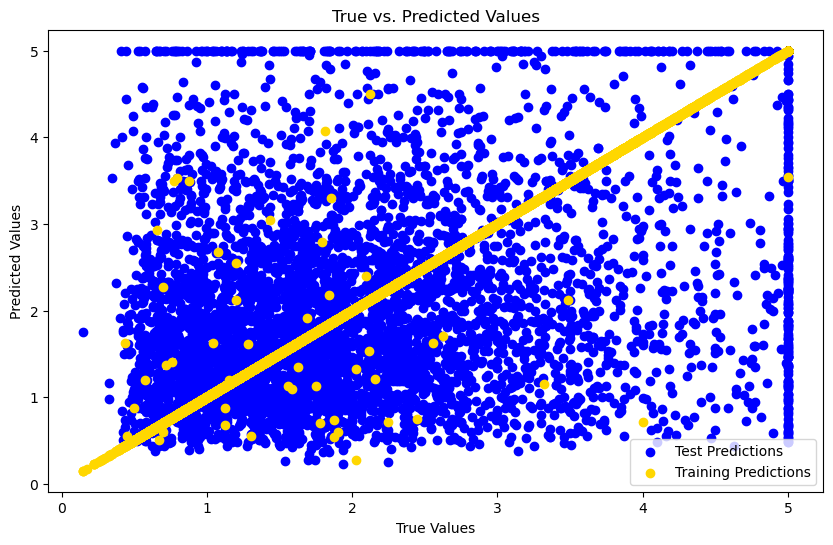

In [36]:
# your code here
## model1: 2 features
### all features are: 'MedInc','HouseAge','AveRooms','AveBedrms','Population','DistCoast','Inland'
#choose the features
features_Norm = ['HouseAgeNorm', 'AveRoomsNorm']
target = 'MedHouseVal'

#data preparation
X_train = cal_df_train[features_Norm]
y_train = cal_df_train[target]
X_test = cal_df_test[features_Norm]
y_test = cal_df_test[target]
# print(X_train.head(3))
# print(y_test.head(3))

#prediction
#trainset prediction
train_predictions = nearest_neighbor_algorithm(X_train, y_train, X_train)

#running time
start_time = time.time()
test_predictions = nearest_neighbor_algorithm(X_train, y_train, X_test)
end_time = time.time()
test_time = end_time - start_time

test_rmse = compute_rmse(test_predictions, y_test)
train_rmse = compute_rmse(train_predictions, y_train)
print(f"Test RMSE: {test_rmse}")
print(f"Training RMSE: {train_rmse}")
print(f"Total prediction time for test set: {test_time} seconds")

#plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, color='blue', label='Test Predictions')
plt.scatter(y_train, train_predictions, color='gold', label='Training Predictions')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
plt.legend()
plt.show()



Test RMSE: 0.9028447612002328
Training RMSE: 0.003142615724477184
Total prediction time for test set: 1.4363195896148682 seconds


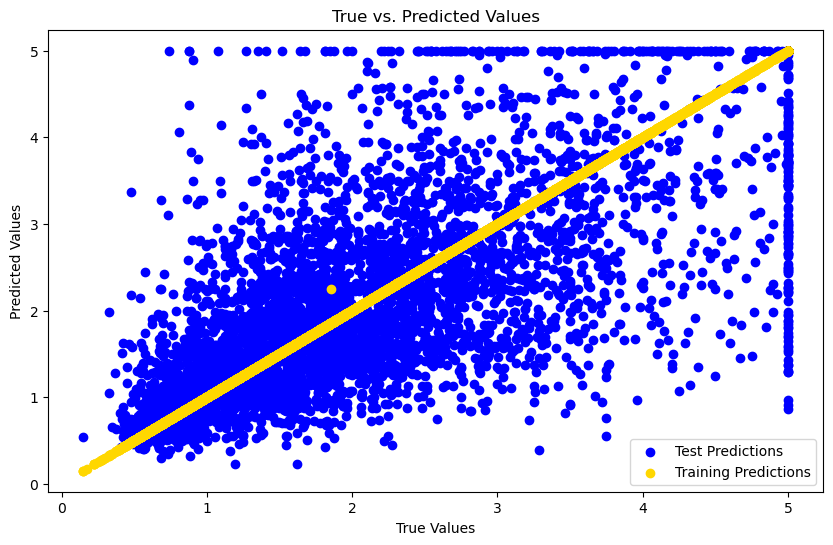

In [37]:
## model2: more than 4 features
### all features are: 'MedInc','HouseAge','AveRooms','AveBedrms','Population','DistCoast','Inland'
#choose the features
features_Norm = ['HouseAgeNorm', 'AveRoomsNorm', 'DistCoastNorm', 'MedIncNorm']
target = 'MedHouseVal'

#data preparation
X_train = cal_df_train[features_Norm]
y_train = cal_df_train[target]
X_test = cal_df_test[features_Norm]
y_test = cal_df_test[target]
# print(X_train.head(3))
# print(y_test.head(3))

#prediction
#trainset prediction
train_predictions = nearest_neighbor_algorithm(X_train, y_train, X_train)

#running time
start_time = time.time()
test_predictions = nearest_neighbor_algorithm(X_train, y_train, X_test)
end_time = time.time()
test_time = end_time - start_time

test_rmse = compute_rmse(test_predictions, y_test)
train_rmse = compute_rmse(train_predictions, y_train)
print(f"Test RMSE: {test_rmse}")
print(f"Training RMSE: {train_rmse}")
print(f"Total prediction time for test set: {test_time} seconds")

#plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, color='blue', label='Test Predictions')
plt.scatter(y_train, train_predictions, color='gold', label='Training Predictions')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
plt.legend()
plt.show()



Test RMSE: 1.0305761007737972
Training RMSE: 0.002732709325632336
Total prediction time for test set: 12.628748893737793 seconds


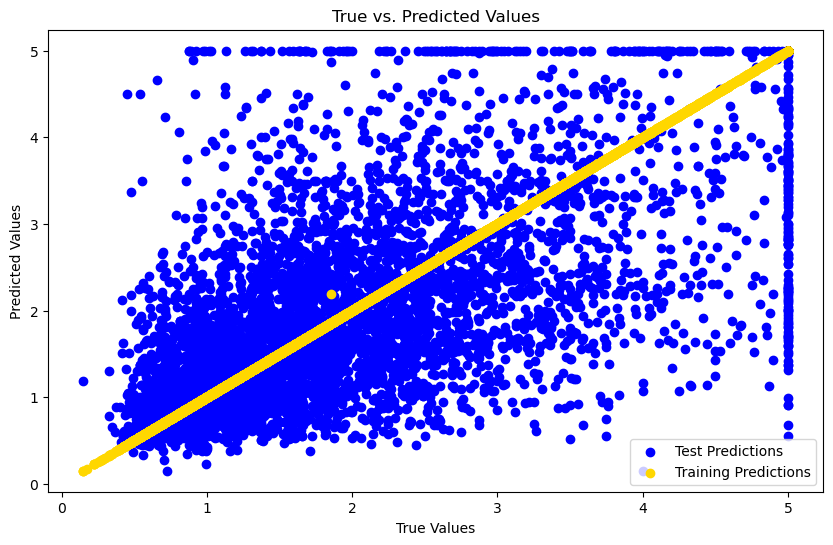

In [38]:
## model3: different value of L
### all features are: 'MedInc','HouseAge','AveRooms','AveBedrms','Population','DistCoast','Inland'
#choose the features
features_Norm = ['MedIncNorm','HouseAgeNorm', 'AveRoomsNorm']
target = 'MedHouseVal'

#data preparation
X_train = cal_df_train[features_Norm]
y_train = cal_df_train[target]
X_test = cal_df_test[features_Norm]
y_test = cal_df_test[target]
# print(X_train.head(3))
# print(y_test.head(3))

#prediction
#trainset prediction
## L=3 is L3 norm
train_predictions = nearest_neighbor_algorithm(X_train, y_train, X_train,3)

#running time
start_time = time.time()
test_predictions = nearest_neighbor_algorithm(X_train, y_train, X_test,3)
end_time = time.time()
test_time = end_time - start_time

test_rmse = compute_rmse(test_predictions, y_test)
train_rmse = compute_rmse(train_predictions, y_train)
print(f"Test RMSE: {test_rmse}")
print(f"Training RMSE: {train_rmse}")
print(f"Total prediction time for test set: {test_time} seconds")

#plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, color='blue', label='Test Predictions')
plt.scatter(y_train, train_predictions, color='gold', label='Training Predictions')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
plt.legend()
plt.show()


*your answer here*  
What combination of features and distance function provide the lowest RMSE on the test set? Do your decisions affect the running time of the algorithm?  
* I tried three models: 1. choose 'HouseAgeNorm', 'AveRoomsNorm' as features with L=2. 2. choose 'HouseAgeNorm', 'AveRoomsNorm', 'DistCoastNorm', 'MedIncNorm' as features with L=2. 3. choose 'MedIncNorm','HouseAgeNorm', 'AveRoomsNorm' as features with L=3.
* It turns out that the model 2 had the best performance with the RMSE in testing set $0.902845$ compared to $1.0119$ in 1.4. And it also cost more calculation time ($ 1.4363195896148682 seconds$)since we considered more features which requires calculation.

### 2.4 K-nearest neighbors algorithm

Now, implement the K-nearest neighbors algorithm and repeat the analysis in 2.1 by using 5 neighbors (`K=5`). The function(s) you write here will be used several more times in this problem set, so do your best to write efficient code! Make sure to do the following:
1. Use your algorithm to predict the median home value of every instance in the test set. Report the RMSE ("test RMSE")
2. Use your algorithm to predict the median home value of every instance in the training set and report the training RMSE.
3. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis.
4. Report an estimate of the total time taken by your code to predict the nearest neighbors for all the values in the test data set.
5. How does the performance (test RMSE and total runtime) of your nearest neighbors algorithm compare to the baseline in part 1.4?

**Note:** Runtime should not exceed a couple of minutes. If its taking longer then we strongly suggest you go back to your code and make it more efficient. 

Test RMSE: 0.7949710611649853
Training RMSE: 0.6423854308236543
Total prediction time for test set: 6.323657035827637 seconds


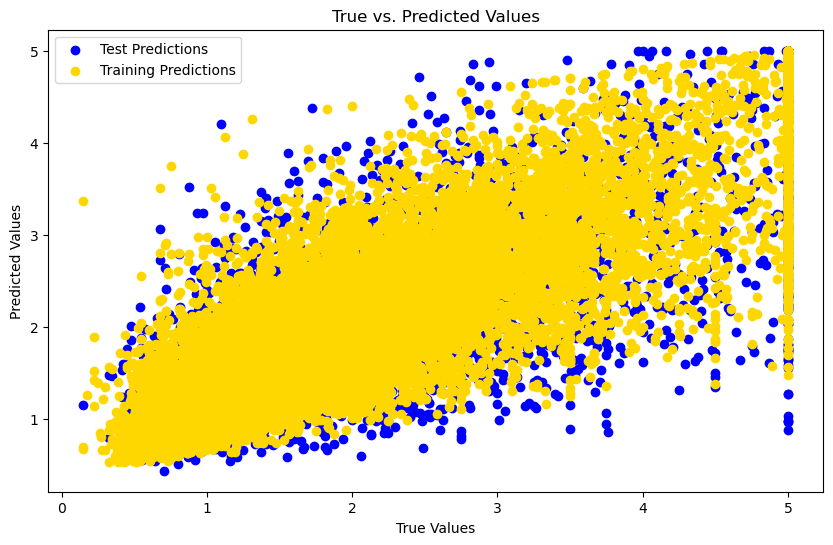

In [39]:
# your code here
def KNN_algorithm(X_train,y_train,X_test,L=2,K=5):
    preds = []
    for x in X_test.values:
        # distance calculation
        distances = np.linalg.norm(X_train-x,axis=1,ord=L)
        # get the nearest K indices
        k_nearest_indices = np.argsort(distances)[:K]   #return index of the k minimum values in X_train 
        # their values 
        k_nearest_values = y_train.iloc[k_nearest_indices]
        # for regression problem
        preds.append(k_nearest_values.mean())
        # if it's classification problem:
        # preds.append(k_nearest_values.mode()[0])
    return preds
#choose the features
features_Norm = ['MedIncNorm', 'HouseAgeNorm', 'AveRoomsNorm']
target = 'MedHouseVal'

#data preparation
X_train = cal_df_train[features_Norm]
y_train = cal_df_train[target]
X_test = cal_df_test[features_Norm]
y_test = cal_df_test[target]
# print(X_train.head(3))
# print(y_test.head(3))

#prediction
#trainset prediction
train_predictions = KNN_algorithm(X_train, y_train, X_train)

#running time
start_time = time.time()
test_predictions = KNN_algorithm(X_train, y_train, X_test)
end_time = time.time()
test_time = end_time - start_time

test_rmse = compute_rmse(test_predictions, y_test)
train_rmse = compute_rmse(train_predictions, y_train)
print(f"Test RMSE: {test_rmse}")
print(f"Training RMSE: {train_rmse}")
print(f"Total prediction time for test set: {test_time} seconds")

#plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, color='blue', label='Test Predictions')
plt.scatter(y_train, train_predictions, color='gold', label='Training Predictions')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
plt.legend()
plt.show()

*your answer here*  
How does the performance (test RMSE and total runtime) of your nearest neighbors algorithm compare to the baseline in part 1.4?  
*Test RMSE: 0.7949710611649853
Training RMSE: 0.6423854308236543
Total prediction time for test set: 6.323657035827637 seconds
* the Test RMSE improves a lot with 0.794971061164985327$ compared to $1.0119036022521926$ in 1.4. And it also cost more runtime.

### 2.5 Cross-Validation

How can we choose K without overfitting? As discussed during lecture time, one possible solution is to use [k-fold cross-validation][1] on the training sample.  Here you must implement a simple k-fold cross-validation algorithm yourself.  The function(s) you write here will be used several more times in this problem set, so do your best to write efficient code! 

Use 20-fold cross-validation and report the average RMSE for your K-nearest neighbors model using Euclidean distance with the same set of features used in 2.3 (`MedIncNorm, HouseAgeNorm and AveRoomsNorm`) and 5 neighbors (`K=5`)  as well as the total running time for the full run of 20 folds.  

In other words, randomly divide your training dataset (created in 1.2) into 20 equally-sized samples. For each of the 20 iterations (the "folds"), use 19 samples as "training data" (even though there is no training in k-NN!), and the remaining 1 sample for validation.  Compute the RMSE of that particular validation set, then move on to the next iteration.  

 - Report the average cross-validated RMSE across the 20 iterations and compare to the result you obtained in 2.3. What do you observe?
 - Report the runtime of your algorithm.How does it compare to your previous results?

[1]: http://en.wikipedia.org/wiki/Cross-validation_(statistics)
[2]: http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

**Note 1:** Runtime should not exceed a couple of minutes. If its taking longer then we strongly suggest you go back to your code and make it more efficient. 

**Note 2**: The sklearn package has a built-in [K-fold][2] iterator -- you should *not* be invoking that or any related algorithms in this section of the problem set.

**Note 3:** To perform any randomized operation, only use functions in the *numpy library (np.random)*. Do not use other packages for random functions.

Test RMSE: 0.7949710611649853
Training RMSE: 0.7877338021676317
Total prediction time for test set: 6.699045419692993 seconds


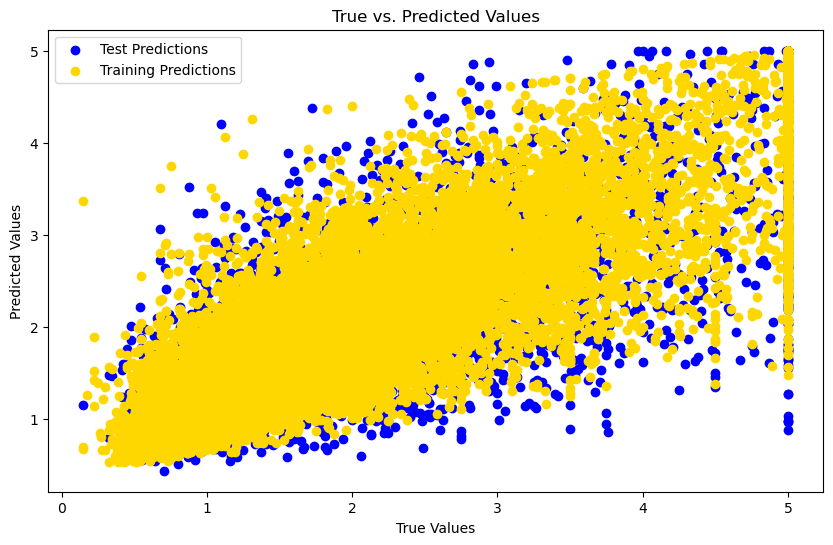

In [41]:
# your code here
# KNN_algorithm in 2.4

# cross-validation
def k_fold_CV(X, y, K = 20, L = 2, KNN_K=5):
    shuffled = np.random.permutation(len(X))
    X_shuffled = X.iloc[shuffled]
    y_shuffled = y.iloc[shuffled]

    #divide the dataset
    fold_size = len(X) // K
    rmse_k = []

    # apply the KNN_algorithm
    for fold in range(K):
        validation_start = fold * fold_size
        validation_end = validation_start + fold_size
        validation_indices = list(range(validation_start,validation_end))

        train_indices = list(range(0, validation_start))+list(range(validation_end,len(X)))

        #get trainset and validationset
        X_train, y_train = X_shuffled.iloc[train_indices], y_shuffled.iloc[train_indices]
        X_val, y_val = X_shuffled.iloc[validation_indices], y_shuffled.iloc[validation_indices]

        #KNN_algoirithm->rmse
        preds = KNN_algorithm(X_train,y_train,X_val,L,KNN_K)
        rmse = compute_rmse(preds, y_val)
        rmse_k.append(rmse)
        
    avg_rmse = np.mean(rmse_k)
    return avg_rmse, rmse_k
    
#choose the features
features_Norm = ['MedIncNorm', 'HouseAgeNorm', 'AveRoomsNorm']
target = 'MedHouseVal'

#data preparation
X_train = cal_df_train[features_Norm]
y_train = cal_df_train[target]
X_test = cal_df_test[features_Norm]
y_test = cal_df_test[target]
# print(X_train.head(3))
# print(y_test.head(3))

#trainset
train_rmse, _ = k_fold_CV(X_train, y_train,K=20,L=2,KNN_K=5)
#running time
start_time = time.time()
test_predictions = KNN_algorithm(X_train, y_train, X_test)
end_time = time.time()
test_time = end_time - start_time

test_rmse = compute_rmse(test_predictions, y_test)
print(f"Test RMSE: {test_rmse}")
print(f"Training RMSE: {train_rmse}")
print(f"Total prediction time for test set: {test_time} seconds")

#plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, color='blue', label='Test Predictions')
plt.scatter(y_train, train_predictions, color='gold', label='Training Predictions')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
plt.legend()
plt.show()

*your anwer here*  

Report the average cross-validated RMSE across the 20 iterations and compare to the result you obtained in 2.3. What do you observe?
Report the runtime of your algorithm.How does it compare to your previous resul  
Test RMSE: 0.7949710611649853
Training RMSE: 0.7877338021676317
Total prediction time for test set: 6.699045419692993 secon  
* ctCompared to the best performance in 2.3 (whose RMSE in testing set is $0.902845$ and running time is $ 1.4363195896148682 seconds$.), the score here is$0.79297$ and $6.699045$ seconds. It shows that the algorithm in 2.5 needs more calculation.
* Compared to the result in 2.4, it's obvious that the training RMSE increased a lot since cross-validation decreases the uncertainty and occasionality of simply using one training set without validation.  : ions.
* 

### 2.6 Using cross validation to find the optimal value for K

Compute the cross-validated RMSE for values of K between 1 and 25 using 10-fold cross-validation and L2 normalization.  Use the following features in your model: `MedIncNorm, HouseAgeNorm and AveRoomsNorm` .  Create a graph that shows how cross-validated RMSE changes as K increases from 1 to 25.  Label your axes, and summarize what you see.  What do you think is a reasonable choice of K for this model?

Finally, "train" a K-nearest neighbor model using the value of K that minimized the cross-validated RMSE and report the test RMSE. (Continue to use L2 normalization and the same set of features). How does the test RMSE compare to the cross-validated RMSE, and is this what you expected? 

**Note:** Runtime should not exceed ~30 min. If its taking longer then we strongly suggest you go back to your code and make it more efficient. 

the 1th iteration
the 2th iteration
the 3th iteration
the 4th iteration
the 5th iteration
the 6th iteration
the 7th iteration
the 8th iteration
the 9th iteration
the 10th iteration
the 11th iteration
the 12th iteration
the 13th iteration
the 14th iteration
the 15th iteration
the 16th iteration
the 17th iteration
the 18th iteration
the 19th iteration
the 20th iteration
the 21th iteration
the 22th iteration
the 23th iteration
the 24th iteration
the 25th iteration


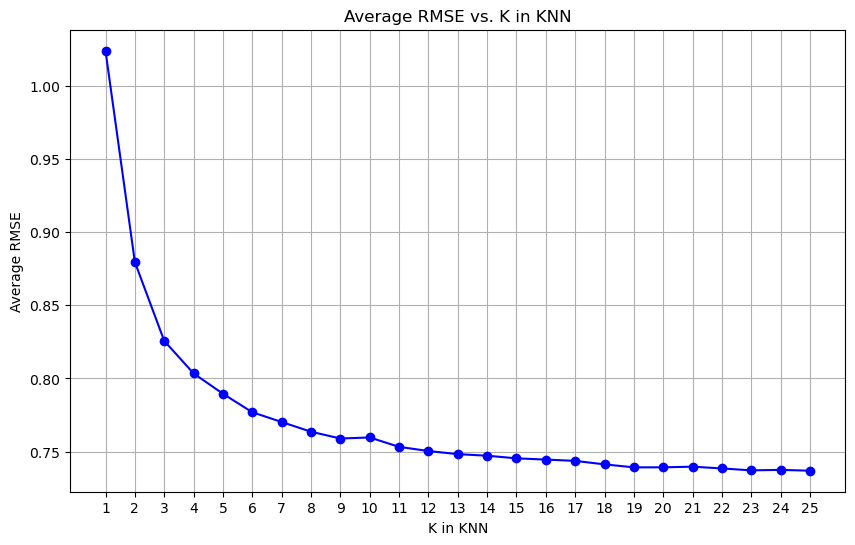

Test RMSE: 0.7439009482082435
Training RMSE: 0.7369404381399536, current K is 25
Total prediction time for test set: 6.382060527801514 seconds


In [43]:
# your code here
# KNN_algorithm is defined in 2.4
# cross-validation is defined in 2.5
def k_fold_CV(X, y, K = 20, L = 2, KNN_K=5):
    shuffled = np.random.permutation(len(X))
    X_shuffled = X.iloc[shuffled]
    y_shuffled = y.iloc[shuffled]

    #divide the dataset
    fold_size = len(X) // K
    rmse_k = []

    # apply the KNN_algorithm
    for fold in range(K):
        validation_start = fold * fold_size
        validation_end = validation_start + fold_size
        validation_indices = list(range(validation_start,validation_end))

        train_indices = list(range(0, validation_start))+list(range(validation_end,len(X)))

        #get trainset and validationset
        X_train, y_train = X_shuffled.iloc[train_indices], y_shuffled.iloc[train_indices]
        X_val, y_val = X_shuffled.iloc[validation_indices], y_shuffled.iloc[validation_indices]

        #KNN_algoirithm->rmse
        preds = KNN_algorithm(X_train,y_train,X_val,L,KNN_K)
        rmse = compute_rmse(preds, y_val)
        rmse_k.append(rmse)
        
    avg_rmse = np.mean(rmse_k)
    return avg_rmse, rmse_k
    
#choose the features
features_Norm = ['MedIncNorm', 'HouseAgeNorm', 'AveRoomsNorm']
target = 'MedHouseVal'

#data preparation
X_train = cal_df_train[features_Norm]
y_train = cal_df_train[target]
X_test = cal_df_test[features_Norm]
y_test = cal_df_test[target]


#k_fold
#find the best K in KNN
#Comparison between this method and Nested CV:
## iteration in K values -> choose one with best performance : conducted one CV for each K
# Nested CV: 
##Consider each split of the k-fold: for each split, we conducted inner CV(k'-fold) (resplit each fold)and chose the best k' (it's actually the same procedure in 2.)
##After the loop, we calculated the mean score of the outer CV from the k-fold
avg_rmses = []
ks = range(1, 26)
best_K = 0
best_rmse = float('inf')
for k in ks:
    print(f"the {k}th iteration")
    avg_rmse, _= k_fold_CV(X_train, y_train, K=10,L=2,KNN_K = k)   
    avg_rmses.append(avg_rmse)
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_K = k


plt.figure(figsize=(10, 6))
plt.plot(ks, avg_rmses, marker='o', linestyle='-', color='b')
plt.title('Average RMSE vs. K in KNN')
plt.xlabel('K in KNN')
plt.ylabel('Average RMSE')
plt.xticks(ks)  
plt.grid(True)
plt.show()

#running time
start_time = time.time()
test_predictions = KNN_algorithm(X_train, y_train, X_test,L=2,K=best_K)
end_time = time.time()
test_time = end_time - start_time

test_rmse = compute_rmse(test_predictions, y_test)

print(f"Test RMSE: {test_rmse}")
print(f"Training RMSE: {best_rmse}, current K is {best_K}")
print(f"Total prediction time for test set: {test_time} seconds")


*your answer here*  
* I think a reasonable choice of K for this model is around 25 becaus the average RMSE is stable and the performance of K=25 is the best.
* The test RMSE is $ 0.7439009482082435$ and is a bit higher than the training RMSE which is $0.7369404381399536$. It's what I expected since it's not much higher and reasonable for the data in testing set. What's more, the RMSE in testing set compared to the result in 2.5. But the number of folds is different, so the result is reasonable.d?

---

# Part III: Overfitting in Model Selection and Nested Cross Validation 


In this last part of the problem set, we will examine why overfitting is a serious concern when estimating hyperparameters and how to address it. 

**For this part of the problem set you are allowed to use machine learning libraries. We don't expect you to use your own algorithms developed in part 2.** We strongly suggest that you use the following libraries and resources, but feel free to choose your favorite Python ML libraries.

In [44]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import joblib

For this part of the problem set we will no longer be using the California Housing Dataset. Instead, we will generate our own synthetic data. The advantage of doing so is that we get to choose the data generating process. We will use the knowledge about the data generating process to test the robustness of different approaches to estimating out-of-sample performance.

We will attempt the following classification problem: predict a binary response variable $y \sim Bernoulli(p=1/2)$ from a set of independent features $X=[x_{1},...,x_{J}]$ where $x_{j} \sim Unif(a=0,b=1)$, $1 \leq j \leq J$. 

You can use the following function to generate samples from this distribution.

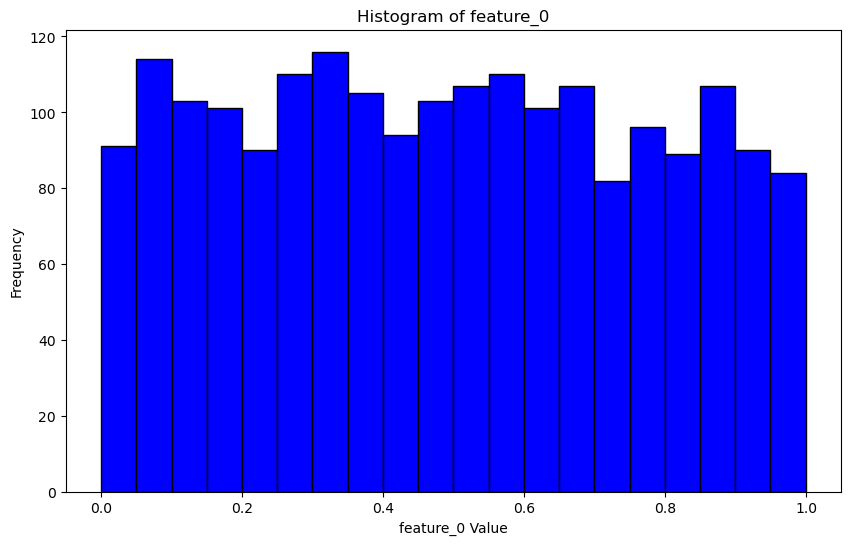

In [45]:
def generate_random_sample(nobs,J):
    X = pd.DataFrame(np.random.random_sample(size=(nobs, J)), columns=[f'feature_{x}' for x in range(J)])
    y = np.random.binomial(n=1,p=1/2,size=nobs)
    return X,y

X_train,y_train = generate_random_sample(nobs=2*10**3,J=100)

# plt.figure(figsize=(10, 6))
# # plt.scatter(X_train['feature_2'], y_train, color='b')
# X_train_x = range(len(X_train))
# X_train_y = X_train['feature_1']
# plt.scatter(X_train_x,X_train_y)
# plt.title('generated data')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.show()

plt.figure(figsize=(10, 6))
plt.hist(X_train['feature_0'], bins=20, color='blue', edgecolor='black')
plt.title('Histogram of feature_0')
plt.xlabel('feature_0 Value')
plt.ylabel('Frequency')
plt.show()

### 3.1 Out-of-sample performance

We are going to be using the area under the ROC curve (AUC-ROC) as the evaluation score. What kind of out-of-sample performance would you expect from classification models trained and tested on this data? Test whether your intuition is correct by carrying out the following iterative procedure:

1. For each iteration in 1,2,3,...,50:
    * Generate a training sample containing 2,000 observations and J=100 features. Likewise, generate a test sample containing 200 observations and J=100 features. 
    * Train some K-nearest neighbors model on the training sample with some arbitrary choice of K (no need to cross validate the choice of K or put any work into it, we'll get to that later on).
    * Evaluate the AUC-ROC on the test set.
2. Plot a histogram of the test AUC-ROC scores.
3. Report the average of the test AUC-ROC scores.

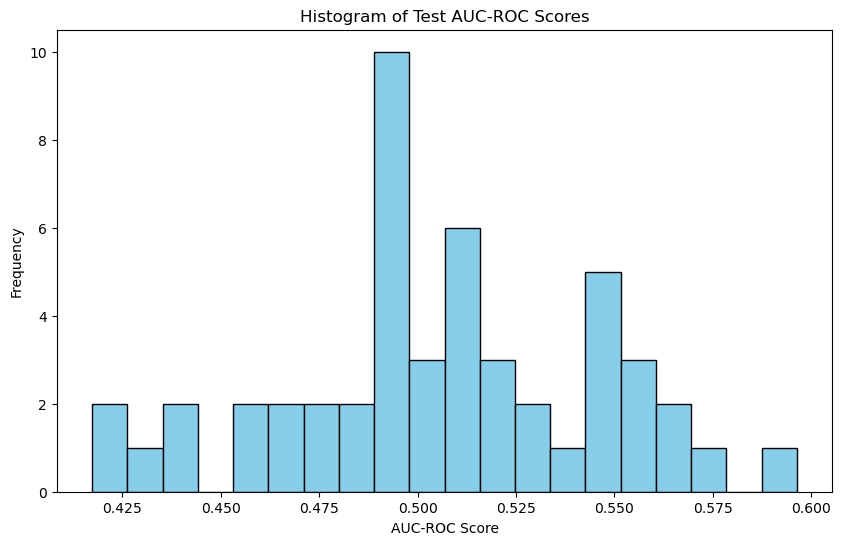

Average Test AUC-ROC Score: 0.5061771625529559


In [47]:
# your code here
auc_scores = []
for i in range(1,51):
    X_train, y_train = generate_random_sample(2000, 100)
    X_test, y_test = generate_random_sample(200, 100)

    # print(X_test.head(3))
    #knn model
    knn = KNeighborsClassifier(n_neighbors = 20)
    knn.fit(X_train.values, y_train)

    #prob of each sample belongs to the feature 1
    y_prob = knn.predict_proba(X_test.values)[:,0]  #all rows and 1st column

    #auc-roc
    auc = roc_auc_score(y_test, y_prob)
    auc_scores.append(auc)

plt.figure(figsize=(10, 6))
plt.hist(auc_scores, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Test AUC-ROC Scores')
plt.xlabel('AUC-ROC Score')
plt.ylabel('Frequency')
plt.show()

average_auc = np.mean(auc_scores)
print(f"Average Test AUC-ROC Score: {average_auc}")

*your answer here*  
Average Test AUC-ROC Score: 0.5061771625529559

### Fix a sample

In real life settings we wouldn't be able to draw test and train samples at will. For the rest of the pset (3.2-3.6) we will fix a training and test sample:

In [64]:
X_train,y_train = generate_random_sample(nobs=2*10**3,J=100)
X_test,y_test = generate_random_sample(nobs=2*10**2,J=100)

### 3.2 k-fold cross-validation 
Use 10-fold cross-validation on the train sample to find the optimal K and report the hyperparameter value. Report also the average of the cross validated scores for the optimal hyperparameter value. 

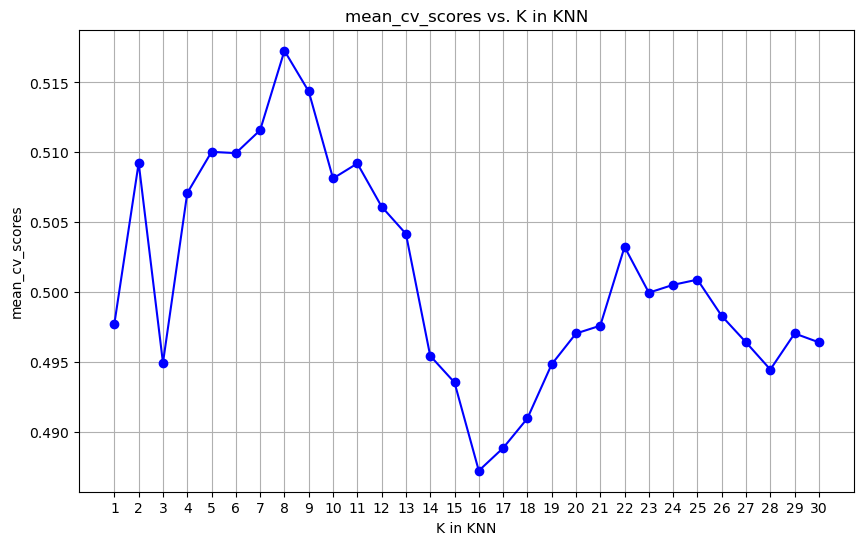

Optimal K: 8
Average Cross-Validated Score for Optimal K: 0.5172688792194966


In [65]:
# your code here
k_range = range(1,31)
# mean_cv_scores = []

# 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
def kfold_CV_3_2(X_train,y_train,kf=kf,k_range=k_range):
    mean_cv_scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        cv_scores = cross_val_score(knn, X_train.values, y_train, cv=kf, scoring='roc_auc')
        mean_cv_scores.append(np.mean(cv_scores))
    return mean_cv_scores

mean_cv_scores = kfold_CV_3_2(X_train,y_train)
optimal_k = k_range[np.argmax(mean_cv_scores)]
optimal_score = max(mean_cv_scores)

plt.figure(figsize=(10, 6))
plt.plot(k_range, mean_cv_scores,marker='o', linestyle='-', color='b')
plt.title('mean_cv_scores vs. K in KNN')
plt.xlabel('K in KNN')
plt.ylabel('mean_cv_scores')
plt.xticks(k_range)  
plt.grid(True)
plt.show()

print(f"Optimal K: {optimal_k}")
print(f"Average Cross-Validated Score for Optimal K: {optimal_score}")

### 3.3 Nested cross-validation

Use nested cross validation ([3],[4],[5],[6]) on the training sample. In the outer loop you should be estimating model performance and in the inner loop you should be doing regular k-fold cross validation to find the optimal K. Use 10 folds for the inner cv and 3 folds for the outer cv. Report the average of the cross-validated scores of the outer loop.

[3]: https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html#sphx-glr-auto-examples-model-selection-plot-nested-cross-validation-iris-py
[4]: https://inria.github.io/scikit-learn-mooc/python_scripts/cross_validation_nested.html#:~:text=As%20a%20conclusion%2C%20when%20optimizing,validation%20are%20often%20overly%20optimistic.
[5]: https://stats.stackexchange.com/questions/65128/nested-cross-validation-for-model-selection/65156#65156
[6]: https://stats.stackexchange.com/questions/232897/how-to-build-the-final-model-and-tune-probability-threshold-after-nested-cross-v/233027#233027

In [66]:
# your code here
# X, y = generate_random_sample(2000, 100)
#using X_train, y_train in "fix a sample"
#KFold: shuffle=True: shuffle the orginal data
##random_state: the random seed. under the same seed, shuffle will outcome the same data split
outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=42)

#Nested CV:
##Consider each split of the k-fold: for each split, we conducted inner CV(k'-fold) (resplit each fold)and chose the best k' (it's actually the same procedure in 2.)
##After the loop, we calculated the mean score of the outer CV from the k-fold
def Nested_CV(X,y,n_neighbors=np.arange(1, 31),outer_cv = outer_cv, inner_cv = inner_cv):
    outer_scores =[]
    for train_index, test_index in outer_cv.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        
        # inner cv: Find the best K
        param_grid = {'n_neighbors': n_neighbors}  # range of k
        knn = KNeighborsClassifier()
    
        # GridSearchCV:
        ## estimator = knn: model; param_grid:the list of hyperparams
        ## scoring: the index for estimation; cv: the split strategy of CV
        grid_search = GridSearchCV(knn, param_grid, cv=inner_cv, scoring='roc_auc')
        grid_search.fit(X_train_fold.values, y_train_fold)
        
        #use the best k to train model in the outer_cv and estimate it in the outer dataset
        best_knn = grid_search.best_estimator_
        # outer_scores.append(cross_val_score(knn, X_train.values, y_train, cv=kf, scoring='roc_auc'))
        outer_scores.append(roc_auc_score(y_test_fold, best_knn.predict_proba(X_test_fold.values)[:, 1]))

        #return the average outer cv AUC-ROS score and the params of the best model
        return outer_scores, best_knn.get_params()
outer_scores, best_knn = Nested_CV(X_train,y_train)
print(best_knn)
# calculate the mean score of the outer_cv 

average_outer_score = np.mean(outer_scores)
print(f"Average outer cross-validated AUC-ROC score: {average_outer_score}")


{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Average outer cross-validated AUC-ROC score: 0.4978998021226839


### 3.4 Take stock of the results so far

Based on the results of 3.1, 3.2 and 3.3, what can you say about estimating out-of-sample performance? Is the average of the cross-validated scores a good estimator? How about the average of the nested cross-validated scores? Are they underestimating or overestimating true out-of-sample performance?

*your answer here*  
* Cross-validated scores:  0.5172688792194966
* They are often overly optimistic.
* Nested cross-validated scores:  0.4978998021226839(average). They did't undersetimate the true out-of-sample performance. And they're actually more closed to the true performance than the Cross-validated scores. Because they considered the uncertainty of the standard cross-validation methods. 

### 3.5 Comparing k-fold and nested cross-validation [extra-credit]

We would like to better assess the difference between the k-fold and nested cross-validation scores and make sure that the results we observed in 3.2 and 3.3 are not a fluke. To do this, repeat both experiments 50 times. In each iteration, pass a different value for the "random_state" parameter in the KFold function to ensure that there is variation in the fold splitting. 

In a single figure, plot two histograms. One showing the distribution of the k-fold scores, another showing the distribution of the nested scores. Use gold for the color of the objects related to the nested scores and blue for the color of the objects related to the k-fold scores. 

**Note 1**: you should NOT be generating a new sample -- continue working with the dataset fixed ahead of question 3.2.

**Note 2**: Runtime should not exceed 30 min. If its taking longer then we strongly suggest you go back to your code and make it more efficient.

Average Cross-Validated Score for Optimal K: 0.5154991458503985
Average outer cross-validated AUC-ROC score: 0.49308853154903226
Average Cross-Validated Score for Optimal K: 0.5204829903292005
Average outer cross-validated AUC-ROC score: 0.49803493057054465
Average Cross-Validated Score for Optimal K: 0.515601451754172
Average outer cross-validated AUC-ROC score: 0.5181069403186606
Average Cross-Validated Score for Optimal K: 0.5187938900117841
Average outer cross-validated AUC-ROC score: 0.534870029888597
Average Cross-Validated Score for Optimal K: 0.5256269510452731
Average outer cross-validated AUC-ROC score: 0.5110906311814422
Average Cross-Validated Score for Optimal K: 0.5218100155381412
Average outer cross-validated AUC-ROC score: 0.5153990407154965
Average Cross-Validated Score for Optimal K: 0.519177061915645
Average outer cross-validated AUC-ROC score: 0.4741585233441911
Average Cross-Validated Score for Optimal K: 0.5180750371159937
Average outer cross-validated AUC-ROC sco

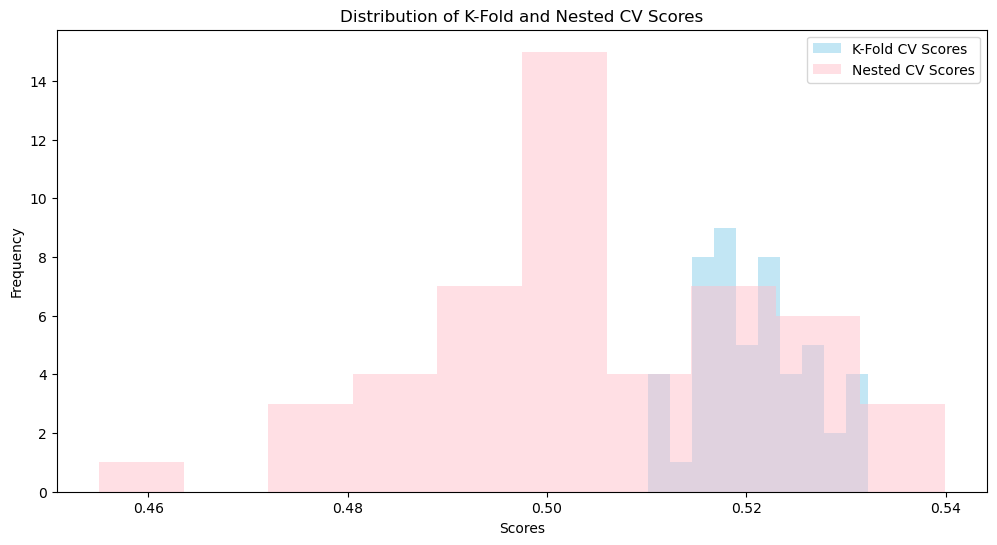

In [67]:
# your code here
# using X_train,y_train
k_range = np.arange(1,31)
std_cv = []
nested_cv = []
for i in range(50):
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=i)
    inner_cv = KFold(n_splits=10, shuffle=True, random_state=i)
    kf = KFold(n_splits=10, shuffle=True, random_state=i)

    #3.2: standard CV
    mean_1 = kfold_CV_3_2(X_train,y_train,kf=kf,k_range=k_range)
    optimal_1 = max(mean_1)
    print(f"Average Cross-Validated Score for Optimal K: {optimal_1}")
    std_cv.append(optimal_1)
    #3.3: Nested CV
    outerscores, best_knn = Nested_CV(X_train,y_train,k_range,outer_cv = outer_cv, inner_cv = inner_cv)
    mean_2 = np.mean(outerscores)
    print(f"Average outer cross-validated AUC-ROC score: {mean_2}")
    nested_cv.append(mean_2)

plt.figure(figsize=(12, 6))
# k-fold scores
plt.hist(std_cv, color='skyblue',bins=10, alpha=0.5, label='K-Fold CV Scores')
# nested scores
plt.hist(nested_cv, color='pink',bins=10, alpha=0.5, label='Nested CV Scores')

plt.legend(loc='upper right')
plt.title('Distribution of K-Fold and Nested CV Scores')
plt.xlabel('Scores')
plt.ylabel('Frequency')

plt.show()

### 3.6 Conclusion [extra-credit]

Based on the figure from 3.5, would you adjust your answer to question 3.4? In a couple of sentences, explain why overfitting can arise when doing model selection, and why nested cross-validation is a useful tool in preventing it. 

*your answer here*  
* No. In 50 iterations the Nested Cross-validated AUC-ROC score is lower than the Standard Cross-validated score.
* 
Overfitting in model selection can arise when a model is excessively complex and captures not only the underlying patterns but also the noise in the training data. This happens particularly when model performance is evaluated on the same data that was used for parameter tuning; the model may appear to perform exceptionally well on this data, but fails to generalize to unseen data
* Nested cross-validation addresses this issue by providing an unbiased evaluation of the model performance. The inner loop is responsible for parameter tuning on a subset of data, while the outer loop evaluates the model's performance on separate unseen data. This separation ensures that the model's ability to generalize is properly assessed, preventing the optimistic bias that can occur from simple cross-validation, which might inadvertently "leak" information about the validation set into the model during parameter tuning.